<a href="https://colab.research.google.com/github/sheikh-bah/Deep_NN_-_CNN/blob/main/transfer_learning_inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
from tensorflow.keras import Model
from tensorflow.keras import layers
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5



--2021-03-06 10:16:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 173.194.69.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  37.8MB/s    in 2.2s    

2021-03-06 10:16:51 (37.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:


from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file_inception = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file_inception)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [5]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape is :', last_layer.output_shape)

Last layer output shape is : (None, 7, 7, 768)


In [10]:
last_output = last_layer.output

# we build our model after getting the pre_trained weights of the Inception 

In [14]:
# Flatten the output layer to one dimension

x = layers.Flatten()(last_output)
# add a fully connected layer with 1024 neuron and a relu activation
x = layers.Dense(1024, activation = 'relu')(x)

# add a droupout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation= 'sigmoid')(x)

In [15]:
model = Model(pre_trained_model.input, x)



In [16]:
from keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [17]:
# now we get the data of the model we want to train
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip


--2021-03-06 11:17:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  75.4MB/s    in 0.9s    

2021-03-06 11:17:39 (75.4 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [19]:
local_zip= '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [21]:
# define our example directories and files

base_dir = '//tmp/cats_and_dogs_filtered'
training_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

cat_training_dir = os.path.join(training_dir, 'cats') # Directory with our trainig cats pictures
dog_training_dir  = os.path.join(training_dir , 'dogs') # Directory with our training dogs pictures

cat_validation_dir = os.path.join(validation_dir , 'cats') # Directory with our validation cats pictures
dog_validation_dir =  os.path.join(validation_dir, 'dogs') # Directory with our validation dogs pictures



Image Preporcessing

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# add image augementation to image datagenerator

train_datagen = ImageDataGenerator(
                 rescale = 1/255,
                 rotation_range = 40,
                 width_shift_range = 0.2,
                 height_shift_range = 0.2,
                 shear_range = 0.2,
                 zoom_range = 0.2,
                 horizontal_flip = True
                
)

validation_datagen = ImageDataGenerator(rescale = 1/255)

# Flow training images in batches of 20 using train_datagen generator

training_generator = train_datagen.flow_from_directory(
                                         training_dir,
                                         target_size = (150,150),
                                         batch_size = 20,
                                         class_mode = 'binary')

validation_generator = validation_datagen.flow_from_directory(
                                validation_dir,
                                target_size = (150,150),
                                batch_size = 20,
                                class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Training our model

In [26]:
history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs = 20,
    steps_per_epoch = 100,
    verbose = 2
)

Epoch 1/20
100/100 - 149s - loss: 1.1722 - accuracy: 0.8555 - val_loss: 0.0984 - val_accuracy: 0.9580
Epoch 2/20
100/100 - 139s - loss: 0.3330 - accuracy: 0.8870 - val_loss: 0.2532 - val_accuracy: 0.9080
Epoch 3/20
100/100 - 139s - loss: 0.2989 - accuracy: 0.9015 - val_loss: 0.2256 - val_accuracy: 0.9270
Epoch 4/20
100/100 - 140s - loss: 0.2471 - accuracy: 0.9255 - val_loss: 0.1718 - val_accuracy: 0.9510
Epoch 5/20
100/100 - 142s - loss: 0.2516 - accuracy: 0.9185 - val_loss: 0.1819 - val_accuracy: 0.9490
Epoch 6/20
100/100 - 142s - loss: 0.2304 - accuracy: 0.9225 - val_loss: 0.1197 - val_accuracy: 0.9660
Epoch 7/20
100/100 - 140s - loss: 0.2270 - accuracy: 0.9270 - val_loss: 0.1058 - val_accuracy: 0.9690
Epoch 8/20
100/100 - 140s - loss: 0.2089 - accuracy: 0.9365 - val_loss: 0.1081 - val_accuracy: 0.9710
Epoch 9/20
100/100 - 143s - loss: 0.1940 - accuracy: 0.9360 - val_loss: 0.1089 - val_accuracy: 0.9640
Epoch 10/20
100/100 - 140s - loss: 0.2123 - accuracy: 0.9340 - val_loss: 0.2144 - 

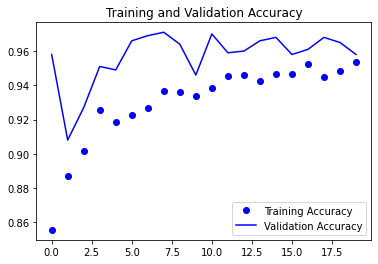

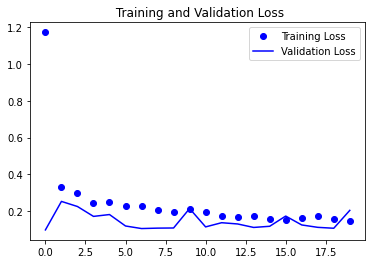

In [30]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc,'b', label = 'Validation Accuracy')
plt.title( 'Training and Validation Accuracy')
plt.legend(loc = 0)
plt.figure()


plt.plot(epochs, loss, 'bo',label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title( ' Training and Validation Loss')
plt.legend()
plt.show()